# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gc
import numpy as np

from keras import backend as K
from sklearn.metrics import fbeta_score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

# Datasets
In this section we will perform the exploratory analysis of the data.

We can see that the code below shows only the labels and the name of each image referring to that label.

In [2]:
#Place the train.csv file
train = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")
train

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


We can also check how many unique labels we have in our dataset

In [4]:
# Checking the labels
classificacoes = train['tags'].unique()  
len(classificacoes)

449

Now we will perform the extraction of these labels and assemble a table with the dismembered labels

In [5]:
# Extracting the Labels
data=train

label_list = []
for tag_str in data.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [6]:
# New Dataset with Labels Visualization
for label in label_list:
    data[label] = data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


From the above dataset, we were able to make a histogram.

With this histogram in hand, we check the number of repetition of labels in the dataset and we realize that it matches the description text of Kaggle's data

<Axes: >

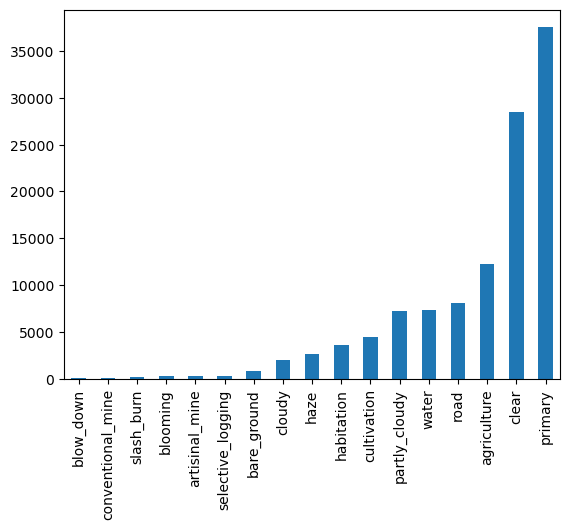

In [7]:
# Histogram of labels
data[label_list].sum().sort_values().plot.bar()

# Loading images

At this point, we will download the training images along with their labels.

To store these images and labels, we must create two variables:

x_train = variable to store training images

y_train = variable to store image labels

In [3]:
#Place the train.csv file
path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64,64)))  
    y_train.append(targets)

# Normalization
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [01:11<00:00, 568.12it/s]


In the test csv file we have two image names, being test_X and file_X.

This is because we have two different files to download the images.

In [4]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")
samplesub

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


From the following code we will find out in which part of the dataset the images with the name file_X begin

In [56]:
item = samplesub.loc[samplesub['image_name'] == 'file_0']
item

,image_name,tags
40669,file_0,primary clear agriculture road water


Now that we know where file_0 is, we can separate our dataset into two parts and later load the images with their respective labels

In [5]:
#Separating the dataset
test = samplesub[0 : 40669]
files = samplesub[40669 : ]

# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0
y_test = np.array(y_test, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 20522/20522 [00:34<00:00, 591.58it/s]


### Image visualization

In this section we will check the dataset images.

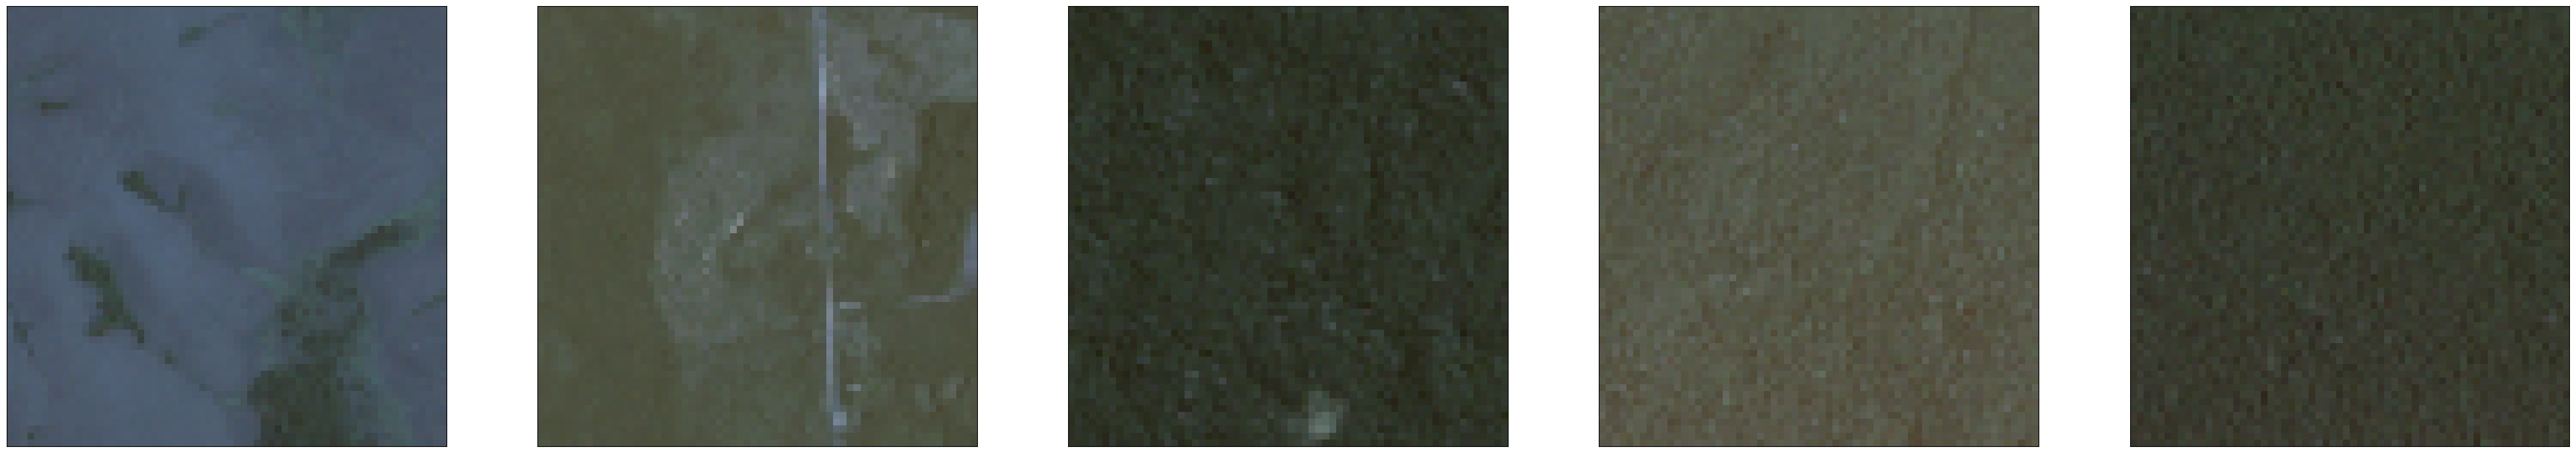

In [6]:
x_train = np.array(x_train, np.float32)

numero_imagens = 5
imagens_teste = np.random.randint(x_train.shape[0], size=numero_imagens)

plt.figure(figsize=(100, 100))

for i, indice_imagem in enumerate(imagens_teste):

    # Imagem original
    eixo = plt.subplot(10,10, i + 1)
    plt.imshow(x_train[indice_imagem].reshape(64,64, 3))
    plt.xticks(())
    plt.yticks(())

plt.show()

Visualization of images in the 4 bands

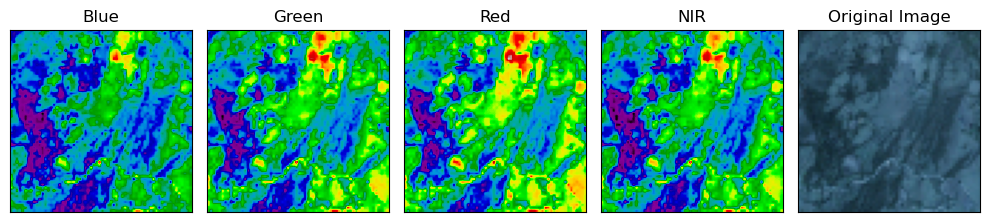

In [19]:
numero_imagens = 1
imagens_teste = np.random.randint(x_train.shape[0], size=numero_imagens)

fig, axes = plt.subplots(1, 5, figsize=(10, 12))
ax = axes.ravel()

for i, indice_imagem in enumerate(imagens_teste):
    ax[i].imshow(x_train[indice_imagem][:, :, 0], cmap='nipy_spectral')
    ax[i].set_title('Blue')
    ax[i].set_xticks(())
    ax[i].set_yticks(())

ax[1].imshow(x_train[indice_imagem][:, :, 1], cmap='nipy_spectral')
ax[1].set_title('Green')
ax[1].set_xticks(())
ax[1].set_yticks(())

ax[2].imshow(x_train[indice_imagem][:, :, 2], cmap='nipy_spectral')
ax[2].set_title('Red')
ax[2].set_xticks(())
ax[2].set_yticks(())

ax[3].imshow((x_train[indice_imagem][:, :, 0] + x_train[indice_imagem][:, :, 1] + x_train[indice_imagem][:, :, 2]) / 3, cmap='nipy_spectral')
ax[3].set_title('NIR')
ax[3].set_xticks(())
ax[3].set_yticks(())

# Plotar imagem original
ax[4].imshow(x_train[indice_imagem])
ax[4].set_title('Original Image')
ax[4].set_xticks(())
ax[4].set_yticks(())



plt.tight_layout()
plt.show()

# Separating Test x Train

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size = 0.3, shuffle = True, random_state = 1)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)

Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)
test data shape: (18358, 64, 64, 3)
test label shape: (18358, 17)


# Evaluation metrics

We will use the evaluation metric proposed by Kaggle itself

In [7]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# Deep Learning 

## CNN 01

In [8]:
filters = 32
filters2 = 64

def create_model1(filters,filters2):
    model = keras.Sequential()
    
    model.add(BatchNormalization(input_shape=(64, 64, 3)))
    
    model.add(Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters2, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[fbeta])
    
    return model

model1 = create_model1(filters,filters2)

In [79]:
history1 = model1.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/10
222/222 [==============================] - 92s 409ms/step - loss: 0.2324 - fbeta: 0.6399 - val_loss: 0.2650 - val_fbeta: 0.6068
Epoch 2/10
222/222 [==============================] - 87s 394ms/step - loss: 0.1969 - fbeta: 0.6938 - val_loss: 0.2446 - val_fbeta: 0.6098
Epoch 3/10
222/222 [==============================] - 87s 394ms/step - loss: 0.1830 - fbeta: 0.7199 - val_loss: 0.1888 - val_fbeta: 0.7066
Epoch 4/10
222/222 [==============================] - 87s 394ms/step - loss: 0.1726 - fbeta: 0.7361 - val_loss: 0.1768 - val_fbeta: 0.7554
Epoch 5/10
222/222 [==============================] - 90s 404ms/step - loss: 0.1654 - fbeta: 0.7453 - val_loss: 0.1607 - val_fbeta: 0.7706
Epoch 6/10
222/222 [==============================] - 87s 392ms/step - loss: 0.1602 - fbeta: 0.7554 - val_loss: 0.1564 - val_fbeta: 0.7769
Epoch 7/10
222/222 [==============================] - 89s 399ms/step - loss: 0.1541 - fbeta: 0.7652 - val_loss: 0.1494 - val_fbeta: 0.7585
Epoch 8/10
222/222 [=======

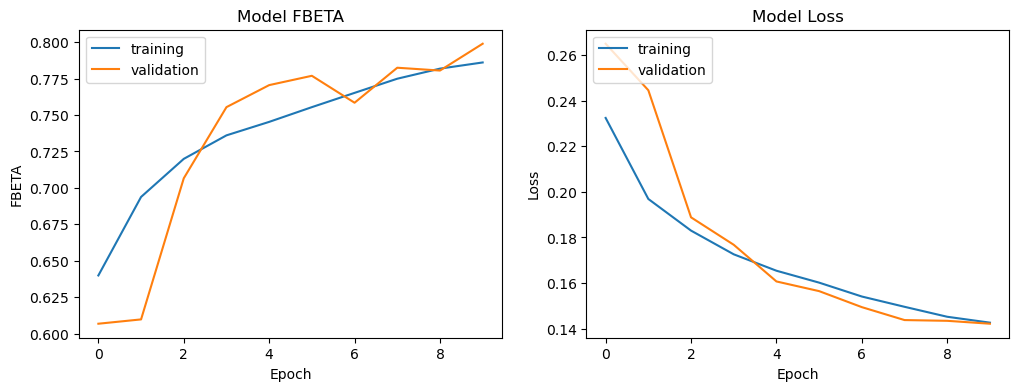

In [81]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['fbeta'])
plt.plot(history1.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [88]:
# Evaluate the model on the validation set
model1.evaluate(x_val, y_val)

# Calculate the f-beta score for the training set
train_fscore = fbeta_score(y_train, np.round(model1.predict(x_train)), beta=2,average = 'weighted')
print("train fscore: ", train_fscore)

# Calculate the f-beta score for the validation set
val_fscore = fbeta_score(y_val, np.round(model1.predict(x_val)), beta=2, average = 'weighted')
print("val fscore: ", val_fscore)

886/886 [==============================] - 16s 18ms/step
train fscore:  0.7909635810083523
380/380 [==============================] - 7s 18ms/step
val fscore:  0.7818798062968023


In [321]:
# Evaluate the model on the test set
test_loss, test_fbeta = model1.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Fbeta:", test_fbeta)

574/574 [==============================] - 16s 27ms/step - loss: 0.4645 - fbeta: 0.5065
Test Loss: 0.4645136296749115
Test Fbeta: 0.5065029263496399


## CNN 02

In [83]:
filters = 64
filters2 = 128

def create_model2(filters,filters2):
    model = keras.Sequential()
    
    model.add(BatchNormalization(input_shape=(64, 64, 3)))
    
    model.add(Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters2, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[fbeta])
    return model

model2 = create_model2(filters,filters2)

In [85]:
history2 = model2.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/10
222/222 [==============================] - 385s 2s/step - loss: 0.2356 - fbeta: 0.6317 - val_loss: 0.2581 - val_fbeta: 0.6619
Epoch 2/10
222/222 [==============================] - 377s 2s/step - loss: 0.1972 - fbeta: 0.6984 - val_loss: 0.2803 - val_fbeta: 0.6171
Epoch 3/10
222/222 [==============================] - 373s 2s/step - loss: 0.1755 - fbeta: 0.7363 - val_loss: 0.1756 - val_fbeta: 0.7309
Epoch 4/10
222/222 [==============================] - 381s 2s/step - loss: 0.1598 - fbeta: 0.7599 - val_loss: 0.1503 - val_fbeta: 0.7620
Epoch 5/10
222/222 [==============================] - 374s 2s/step - loss: 0.1496 - fbeta: 0.7777 - val_loss: 0.1418 - val_fbeta: 0.7834
Epoch 6/10
222/222 [==============================] - 371s 2s/step - loss: 0.1422 - fbeta: 0.7876 - val_loss: 0.1389 - val_fbeta: 0.7823
Epoch 7/10
222/222 [==============================] - 371s 2s/step - loss: 0.1366 - fbeta: 0.7968 - val_loss: 0.1324 - val_fbeta: 0.7985
Epoch 8/10
222/222 [=====================

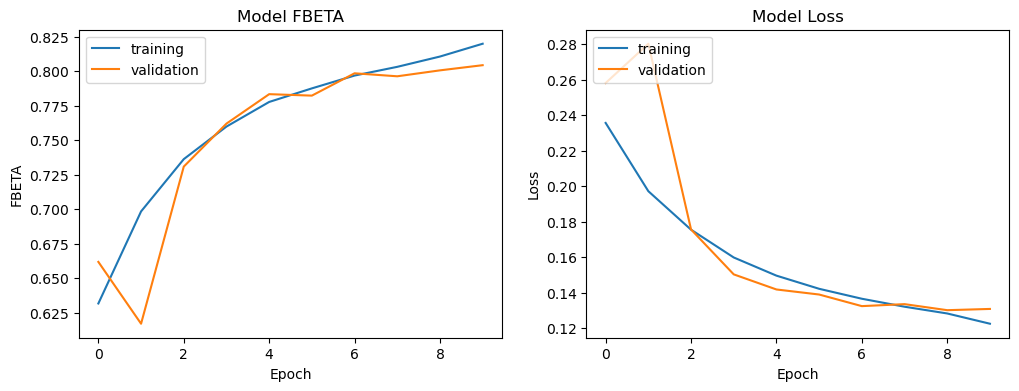

In [86]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['fbeta'])
plt.plot(history2.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()


In [89]:

# Evaluate the model on the validation set
model2.evaluate(x_val, y_val)

# Calculate the f-beta score for the training set
train_fscore = fbeta_score(y_train, np.round(model2.predict(x_train)), beta=2,average = 'weighted')
print("train fscore: ", train_fscore)

# Calculate the f-beta score for the validation set
val_fscore = fbeta_score(y_val, np.round(model2.predict(x_val)), beta=2, average = 'weighted')
print("val fscore: ", val_fscore)

886/886 [==============================] - 69s 78ms/step
train fscore:  0.8223204548026324
380/380 [==============================] - 30s 78ms/step
val fscore:  0.791253654003416


In [322]:
# Evaluate the model on the test set
test_loss, test_fbeta = model2.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Fbeta:", test_fbeta)

574/574 [==============================] - 100s 174ms/step - loss: 0.6912 - fbeta: 0.4768
Test Loss: 0.6911502480506897
Test Fbeta: 0.4767998456954956


## CNN 03

In [90]:
filters = 128
filters2 = 256

model3 = create_model2(filters,filters2)

In [91]:
history3 = model3.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/10
222/222 [==============================] - 972s 4s/step - loss: 0.2408 - fbeta: 0.6277 - val_loss: 0.2713 - val_fbeta: 0.6069
Epoch 2/10
222/222 [==============================] - 966s 4s/step - loss: 0.1993 - fbeta: 0.6917 - val_loss: 0.2515 - val_fbeta: 0.6619
Epoch 3/10
222/222 [==============================] - 908s 4s/step - loss: 0.1792 - fbeta: 0.7269 - val_loss: 0.1793 - val_fbeta: 0.7270
Epoch 4/10
222/222 [==============================] - 912s 4s/step - loss: 0.1633 - fbeta: 0.7541 - val_loss: 0.1532 - val_fbeta: 0.7778
Epoch 5/10
222/222 [==============================] - 914s 4s/step - loss: 0.1525 - fbeta: 0.7725 - val_loss: 0.1425 - val_fbeta: 0.7845
Epoch 6/10
222/222 [==============================] - 914s 4s/step - loss: 0.1448 - fbeta: 0.7843 - val_loss: 0.1378 - val_fbeta: 0.7894
Epoch 7/10
222/222 [==============================] - 917s 4s/step - loss: 0.1395 - fbeta: 0.7916 - val_loss: 0.1402 - val_fbeta: 0.7745
Epoch 8/10
222/222 [=====================

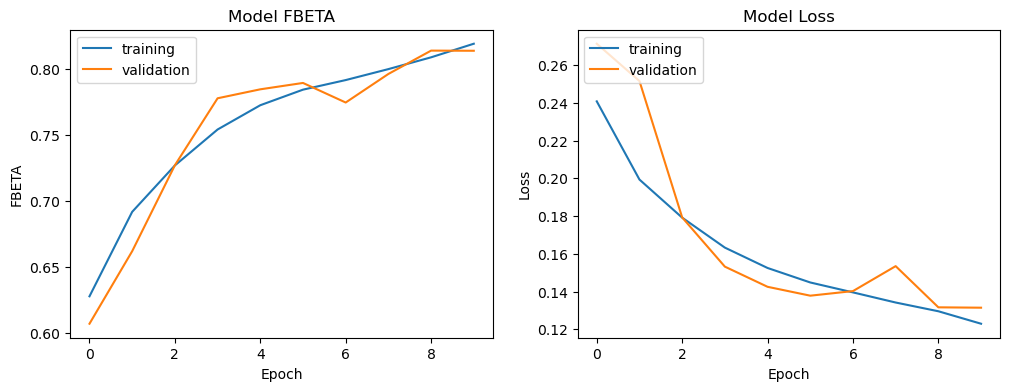

In [92]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['fbeta'])
plt.plot(history3.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [93]:
# Evaluate the model on the validation set
model3.evaluate(x_val, y_val)

# Calculate the f-beta score for the training set
train_fscore = fbeta_score(y_train, np.round(model3.predict(x_train)), beta=2,average = 'weighted')
print("train fscore: ", train_fscore)

# Calculate the f-beta score for the validation set
val_fscore = fbeta_score(y_val, np.round(model3.predict(x_val)), beta=2, average = 'weighted')
print("val fscore: ", val_fscore)

886/886 [==============================] - 216s 243ms/step
train fscore:  0.829608267435663
380/380 [==============================] - 95s 249ms/step
val fscore:  0.7998725495772783


In [323]:
# Evaluate the model on the test set
test_loss, test_fbeta = model3.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Fbeta:", test_fbeta)

574/574 [==============================] - 329s 570ms/step - loss: 0.6459 - fbeta: 0.4945
Test Loss: 0.6459181904792786
Test Fbeta: 0.4944639801979065


Considering that we do not have a GPU to accelerate our simulations, we will carry out tests with dimensionality reduction using 2D2PCA and we will use pre-trained models such as ResNet, MobileNet and EfficientNet, to help compose the Baseline.

Soon, a folder called "Baseline" will be created with all these tests.

## CNN 04

In [69]:
def create_model():
    model = keras.Sequential()
    
    model.add(BatchNormalization(input_shape=(64, 64, 3)))
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model

model = create_model()

In [70]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[fbeta])

In [71]:
history = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/10
253/253 [==============================] - 201s 771ms/step - loss: 0.2039 - fbeta: 0.6949 - val_loss: 0.2007 - val_fbeta: 0.6762
Epoch 2/10
253/253 [==============================] - 188s 742ms/step - loss: 0.1574 - fbeta: 0.7678 - val_loss: 0.1460 - val_fbeta: 0.7832
Epoch 3/10
253/253 [==============================] - 188s 741ms/step - loss: 0.1401 - fbeta: 0.7942 - val_loss: 0.1380 - val_fbeta: 0.7825
Epoch 4/10
253/253 [==============================] - 188s 745ms/step - loss: 0.1327 - fbeta: 0.8065 - val_loss: 0.1253 - val_fbeta: 0.8093
Epoch 5/10
253/253 [==============================] - 187s 738ms/step - loss: 0.1253 - fbeta: 0.8196 - val_loss: 0.1231 - val_fbeta: 0.8178
Epoch 6/10
253/253 [==============================] - 188s 742ms/step - loss: 0.1200 - fbeta: 0.8290 - val_loss: 0.1204 - val_fbeta: 0.8297
Epoch 7/10
253/253 [==============================] - 187s 741ms/step - loss: 0.1132 - fbeta: 0.8400 - val_loss: 0.1195 - val_fbeta: 0.8247
Epoch 8/10
253/253 [

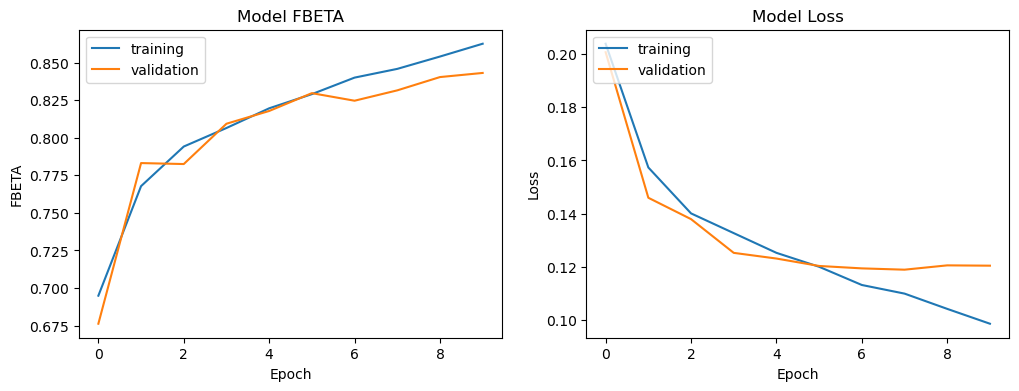

In [72]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [74]:
# Evaluate the model on the test set
test_loss, test_fbeta = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Fbeta:", test_fbeta)

574/574 [==============================] - 19s 34ms/step - loss: 1.3913 - fbeta: 0.4037
Test Loss: 1.3913295269012451
Test Fbeta: 0.40371376276016235


# Carrying out the prediction

In this section we will perform the prediction of the test dataset.

Therefore, we will gather all the test images and put them in a list and use a model to predict the classes.

In [76]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

#
test = samplesub[0 : 40669]
files = samplesub[40669 : ]
# Initialize an empty list to store the images
test_img = []

# Loop through the test DataFrame
for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))
    # Loop through the additional test files DataFrame
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Convert the list of images to a numpy array and normalize the pixel values
test_img = np.array(test_img, np.float16)/255.0

100%|███████████████████████████████████████████████████████████████████████████| 20522/20522 [01:24<00:00, 242.39it/s]


In [79]:
# free memory
gc.collect()

42019

In [80]:
# Running the predictions

# Initialize an empty list to store the predictions
lista = []

# Make predictions on the test images using the model
predictions = model1.predict(test_img, batch_size = 128, verbose = 2)

# Append the predictions to the lista list
lista.append(predictions)

479/479 - 54s - 54s/epoch - 113ms/step


In [81]:
# Convert the encoded labels back to their original form

# Initialize an empty array to store the decoded labels
sub = np.array(lista[0])

# Loop through the encoded labels
for i in range (1, len(lista)):
    # Add the encoded label to the array
    sub += np.array(lista[i])

# Convert the array to a DataFrame
sub = pd.DataFrame(sub, columns = label_map)
sub

,conventional_mine,cultivation,artisinal_mine,blooming,selective_logging,slash_burn,blow_down,clear,cloudy,habitation,bare_ground,road,primary,partly_cloudy,haze,agriculture,water
0,2.314825e-06,0.001803,3.321989e-06,6.507238e-03,2.767671e-04,1.769002e-05,1.637444e-04,9.993529e-01,1.344535e-06,0.000457,2.018569e-04,0.001120,0.999988,1.429015e-04,3.111971e-04,0.003326,0.011485
1,5.004975e-07,0.000510,1.466048e-06,2.180627e-03,8.239228e-05,9.398553e-06,1.577678e-04,9.984184e-01,1.191803e-06,0.000249,7.584146e-05,0.000400,0.999991,5.485454e-04,4.418616e-05,0.001328,0.007742
2,2.038302e-13,0.000056,6.820726e-11,7.074140e-11,3.512563e-11,6.357818e-08,3.060491e-09,3.026666e-08,1.857027e-11,0.000009,6.262355e-08,0.000080,1.000000,1.000000e+00,1.415236e-10,0.000632,0.009783
3,2.269327e-05,0.216913,6.818122e-05,2.255579e-02,2.996885e-03,1.800970e-03,7.037916e-03,8.889296e-01,4.124680e-05,0.002982,2.246164e-03,0.007858,0.999888,9.148353e-02,4.285348e-03,0.164751,0.054217
4,3.587438e-09,0.000043,7.922299e-07,2.278471e-09,3.511379e-10,6.357222e-09,2.182865e-10,2.632765e-05,6.069687e-02,0.000083,8.155031e-06,0.000848,0.843071,9.087573e-01,9.007304e-08,0.002637,0.137758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,1.929235e-07,0.000890,3.178859e-06,3.176166e-07,7.278834e-07,1.193796e-07,4.194798e-08,1.419425e-05,9.383719e-02,0.001537,9.066595e-06,0.007760,0.915620,8.711060e-01,1.402959e-06,0.010865,0.017887
61187,1.174625e-06,0.058452,2.265151e-07,3.906664e-06,5.443812e-07,1.312109e-05,2.170156e-08,9.999917e-01,8.558865e-10,0.004728,3.253063e-03,0.049324,0.999973,1.123413e-07,9.724859e-06,0.272714,0.965346
61188,3.499013e-05,0.084767,7.185608e-05,1.277368e-02,5.094334e-03,4.271137e-04,1.029742e-03,9.996644e-01,6.388238e-07,0.006557,2.084880e-03,0.048518,0.999960,1.599478e-04,1.487626e-04,0.085398,0.365447
61189,3.763612e-07,0.000184,3.224124e-06,1.685510e-06,1.040855e-06,1.339783e-06,1.734885e-06,3.034340e-03,9.287223e-01,0.000224,1.091499e-05,0.001715,0.074953,1.354638e-03,1.097517e-01,0.002965,0.017395


In [82]:
# Create the submission file format

# Initialize an empty list to store the predictions
preds = []

# Loop through the sample submission DataFrame
for i in tqdm(range(sub.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    a = sub.loc[[i]]
    # Apply a lambda function to get a Boolean array indicating which columns have values greater than 0.2
    a = a.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    a = a.transpose()
    # Get the rows where the Boolean array is True
    a= a.loc[a[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    ' '.join(list(a.index))
    # Append the string of tags to the preds list
    preds.append(' '.join(list(a.index)))

# Assign the preds list as the 'tags' column of the sample submission DataFrame
samplesub['tags'] = preds

# Save the sample submission DataFrame to a CSV file
samplesub.to_csv('CMT_submission.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████| 61191/61191 [01:14<00:00, 819.87it/s]
